In [94]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [95]:
print(tf.__version__)

2.3.1


In [96]:
dataset = r'/home/jon/'

dataset_dir = os.path.join(os.path.dirname(dataset), 'stackOverflow')


In [97]:
os.listdir(dataset_dir)

['train', 'test']

In [98]:
train_dir = os.path.join(dataset_dir, 'train')

In [99]:
os.listdir(train_dir)

['csharp', 'javascript', 'java', 'python']

In [100]:
sample_file = os.path.join(train_dir, 'python/0.txt')
with open(sample_file) as f:
    print(f.read())

"is it legal to define two methods with the same name but different returning types? i've written a piece of code to determine a typical palindrome string. i did this by the definition of a reverse() method returning a string. i also eager to have the same method, but in the void form, because of some future needs..as i add the latter to the code, the valid output will become invalid..so, the question is that is it legal to define two methods with the same name but different returning types?.if not, please let me know how to write this code with the void-type method...class detector(object):.    def __init__(self,string):.        self.string = string..    forbidden = (' ','!','?','.','-','_','&amp;','%',""#"","","")..    def eliminator(self):.        for item in self.forbidden:.            if item in self.string:.                self.string = self.string.replace(item,"""")..    def reverse(self):.        return self.string[::-1]            ..    #def reverse(self):.    #    self.string

In [101]:
#remove_dir = os.path.join(train_dir, 'unsup')
#shutil.rmtree(remove_dir)

In [102]:
seed = 42
batch_size = 32

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'stackOverflow/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)


Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [103]:
for text_batch, label_batch in raw_train_ds.take(1):
    for i in range(3):
        print("text", text_batch.numpy()[i])
        print("Label", label_batch.numpy()[i])

text b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default construct

In [104]:
print("Label 0 corresponds to: ", raw_train_ds.class_names[0])
print("Label 1 corresponds to: ", raw_train_ds.class_names[1])
print("Label 2 corresponds to: ", raw_train_ds.class_names[2])
print("Label 3 corresponds to: ", raw_train_ds.class_names[3])

Label 0 corresponds to:  csharp
Label 1 corresponds to:  java
Label 2 corresponds to:  javascript
Label 3 corresponds to:  python


In [105]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'stackOverflow/train',
            batch_size=batch_size,
            validation_split=0.2,
            subset='validation',
            seed=seed)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [106]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
            'stackOverflow/test',
            batch_size=batch_size)

Found 8000 files belonging to 4 classes.


In [107]:
def custom_standardization(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
    return tf.strings.regex_replace(stripped_html, '[%s]' % re.escape(string.punctuation), '')

In [108]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(standardize=custom_standardization,
                                   max_tokens=max_features,
                                   output_mode='int',
                                   output_sequence_length=sequence_length)

In [109]:
train_text = raw_train_ds.map(lambda x, y:x)
vectorize_layer.adapt(train_text)

In [110]:
def vectorize_text(text, label):
    text = tf.expand_dims(text, -1)
    return vectorize_layer(text), label

In [111]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("text: ", first_review)
print("label: ", raw_train_ds.class_names[first_label])
print("vectorized review: ", vectorize_text(first_review, first_label))

text:  tf.Tensor(b'"unit testing of setters and getters teacher wanted us to do a comprehensive unit test. for me, this will be the first time that i use junit. i am confused about testing set and get methods. do you think should i test them? if the answer is yes; is this code enough for testing?..  public void testsetandget(){.    int a = 10;.    class firstclass = new class();.    firstclass.setvalue(10);.    int value = firstclass.getvalue();.    assert.asserttrue(""error"", value==a);.  }...in my code, i think if there is an error, we can\'t know that the error is deriving because of setter or getter."\n', shape=(), dtype=string)
label:  java
vectorized review:  (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[1011,  773,    9, 2456,    8, 1863, 2362,  690, 1267,    4,   40,
           5,    1, 1011,  196,   12,   74,   13,   72,   33,    2,   98,
         105,   14,    3,   70, 9611,    3,   34,  888,  202,  773,  107,
           8,   41,  242,   40,   58,  291,   90,    3

In [112]:
print('107--->', vectorize_layer.get_vocabulary()[107])
print('313---->', vectorize_layer.get_vocabulary()[313])
print(f'vocab size:{len(vectorize_layer.get_vocabulary())} ')

107---> set
313----> source
vocab size:10000 


In [113]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [114]:
AUTOTUNE = tf.data.experimental.AUTOTUNE


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
vel_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [115]:
embedded_dim = 16

In [116]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features + 1, embedded_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(4)])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 68        
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
_________________________________________________________________


In [117]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             optimizer='adam',
             metrics=['accuracy'])

In [118]:
epochs = 10
history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[callback])

Epoch 1/10
200/200 [==============================] - 2s 8ms/step - loss: 1.3778 - accuracy: 0.3577 - val_loss: 1.3661 - val_accuracy: 0.4506
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 1.3470 - accuracy: 0.4827 - val_loss: 1.3253 - val_accuracy: 0.5200
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2924 - accuracy: 0.5437 - val_loss: 1.2617 - val_accuracy: 0.5838
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 1.2168 - accuracy: 0.6019 - val_loss: 1.1820 - val_accuracy: 0.6369
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1309 - accuracy: 0.6556 - val_loss: 1.0991 - val_accuracy: 0.6775
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 1.0461 - accuracy: 0.6970 - val_loss: 1.0222 - val_accuracy: 0.7056
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9695 - accuracy: 0.7272 - val_loss: 0.9547 - val_accuracy: 0.7188
Epoch 

In [119]:
loss, accuracy = model.evaluate(test_ds)
print('loss: ', loss)
print('accuracy: ', accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 0.8378 - accuracy: 0.7379
loss:  0.8377957940101624
accuracy:  0.7378749847412109


In [120]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

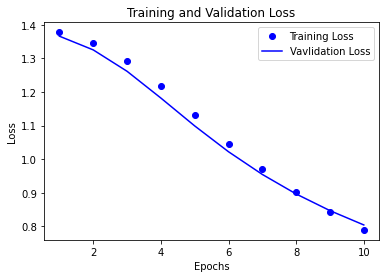

In [121]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

#bo is for blue dot
plt.plot(epochs, loss, 'bo', label='Training Loss')
#b is for solid blue line
plt.plot(epochs, val_loss, 'b', label='Vavlidation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

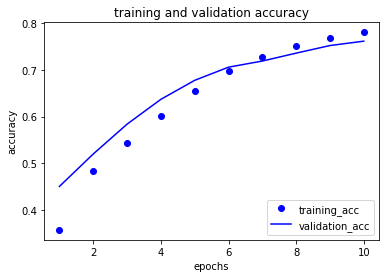

In [122]:
plt.plot(epochs, acc, 'bo', label='training_acc')
plt.plot(epochs, val_acc, 'b', label='validation_acc')
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(loc='lower right')

plt.show()

In [123]:
export_model = tf.keras.Sequential([
            vectorize_layer,
            model,
            tf.keras.layers.Activation('sigmoid')
])

export_model.compile(
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        optimizer='adam',
        metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 1s 4ms/step - loss: 1.0862 - accuracy: 0.7379
0.7378749847412109


In [126]:
examples = [
    'console.writeline and console.readkey',
    'print()',
    'import tensorflow'
]

export_model.predict(examples)

array([[0.5400683 , 0.45499384, 0.54402304, 0.45648497],
       [0.49428535, 0.45081446, 0.5413548 , 0.5007138 ],
       [0.49557546, 0.45432922, 0.53758794, 0.50129706]], dtype=float32)